In [1]:
# common recipe to get access to the source inside src
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
##########################################################

import numpy as np
from pathlib import Path

from models.CaptionModalityClassifier import CaptionModalityClassifier # caption modality classifier
from dataset.MultimodalityDataModule import MultimodalityDataModule    # pytorch lightning data module for captions and images
from utils.caption_utils import load_glove_matrix                      # utils for embeddings
from models.MultiModalityClassifier import MultiModalityClassifier

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import WandbLogger

In [2]:
model_names = ['pretty-violet-110', 'earnest-haze-109', 'sage-elevator-108']
#model_names = ['gentle-firebrand-183']

In [3]:
MAX_NUMBER_WORDS = 20000       # number of words to consider from embeddings vocabulary
MAX_WORDS_PER_SENTENCE = 300   # sentence maximum length
NUM_CLASSES = 4                # 4 microscopy classes

In [4]:
BASE_PATH = Path('/workspace/data')
DATA_PATH = BASE_PATH / 'multimodality_classification.csv'
OUTPUT_DIR = Path('./outputs')
BASE_IMG_DIR = BASE_PATH       # the image path in the CSV file are relative to this directory
NUM_WORKERS = 72   

In [5]:
dm = MultimodalityDataModule(32,
                             str(DATA_PATH),
                             MAX_NUMBER_WORDS,
                             MAX_WORDS_PER_SENTENCE,
                             str(BASE_IMG_DIR),
                             num_workers=NUM_WORKERS)
dm.prepare_data()
dm.setup()

print("Current vocabulary size: {0}".format(dm.vocab_size))
train_dataloader = dm.train_dataloader()
train_dataset    = train_dataloader.dataset
target_classes   = train_dataset.le.classes_
print("Classes: {0}".format(target_classes))

Current vocabulary size: 7221
Classes: ['DMEL' 'DMFL' 'DMLI' 'DMTR']


In [6]:
import torch, json
from experiments.microscopy.microscopy import experiment, get_model
vision_dict_path = '/workspace/src/experiments/microscopy/shallow-resnet152.json'
vision_model_id = 'resnet152.layer3-11'
vision_outputs_path = '/workspace/outputs'

with open(vision_dict_path) as json_file:
    vision_models = json.load(json_file)
vision_model_name, vision_experiment_name = vision_model_id.split('.')
vision_model = get_model(vision_model_name, "shallow", 4, layers=vision_models[vision_model_id]['layers'], pretrained=True)

checkpoint = torch.load(vision_outputs_path + '/{0}/checkpoint.pt'.format(vision_models[vision_model_id]['id']))
vision_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [52]:
from utils.caption_utils import load_glove_matrix
EMBEDDINGS = BASE_PATH / 'embeddings'
WORD_DIMENSION = 300 

if dm.vocab_size < MAX_NUMBER_WORDS:
    MAX_NUMBER_WORDS = dm.vocab_size

embeddings_matrix = load_glove_matrix(EMBEDDINGS, WORD_DIMENSION, MAX_NUMBER_WORDS, dm.word_index)

Dimension: 300; found 400000 word vectors.


In [12]:
text_model.hparams

"filters":          128
"lr":               0.0001
"max_input_length": 500
"vocab_size":       8938

In [7]:
OUTPUT_PATH = Path('/workspace/src/experiments/microscopy/outputs')

# graceful_moon caption classifier
text_model_path = '/workspace/src/experiments/microscopy/outputs/graceful-moon-64/final.pt'
#text_model_path = '/workspace/nb/outputs/bumbling-dragon-180/final.pt'
#text_model_path = '/workspace/src/experiments/microscopy/outputs/gentle-firebrand-183/final.pt'
text_model = CaptionModalityClassifier.load_from_checkpoint(filters=128,
                                                            embedding_dim=300,
                                                            vocab_size=7221,#8938, 7221,
                                                            num_classes=4,
                                                            train_embedding=False,                                                            
                                                            max_input_length=MAX_WORDS_PER_SENTENCE,
                                                            is_multilabel=False,
                                                            target_classes=None,
                                                            #target_classes=train_dataset.le.classes_,
                                                            checkpoint_path=text_model_path)



In [8]:
checkpoint_path = OUTPUT_PATH / model_names[0] / 'final.pt'
model = MultiModalityClassifier.load_from_checkpoint(text_model=text_model, image_model=vision_model,
                                                     checkpoint_path=str(checkpoint_path))

In [9]:
trainer = Trainer(gpus=1, logger=None)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Accuracy: 50.05727767944336
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(50.0573, device='cuda:0')}
--------------------------------------------------------------------------------



[{'test_acc': 50.05727767944336}]

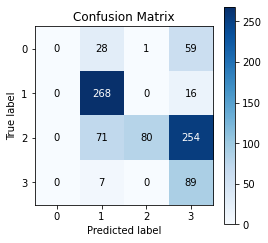

In [10]:
test_dataloader = dm.test_dataloader()
trainer.test(model, test_dataloaders=test_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Accuracy: 88.43070220947266
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(88.4307, device='cuda:0')}
--------------------------------------------------------------------------------



[{'test_acc': 88.43070220947266}]

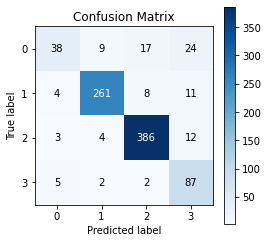

In [10]:
checkpoint_path = OUTPUT_PATH / model_names[1] / 'final.pt'
model = MultiModalityClassifier.load_from_checkpoint(text_model=text_model, image_model=vision_model,
                                                     checkpoint_path=str(checkpoint_path))
trainer = Trainer(gpus=1, logger=None)
trainer.test(model, test_dataloaders=test_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Accuracy: 88.54524993896484
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(88.5452, device='cuda:0')}
--------------------------------------------------------------------------------



[{'test_acc': 88.54524993896484}]

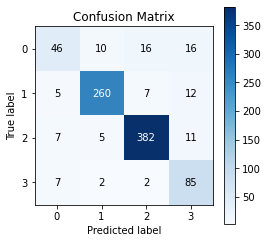

In [11]:
checkpoint_path = OUTPUT_PATH / model_names[2] / 'final.pt'
model = MultiModalityClassifier.load_from_checkpoint(text_model=text_model, image_model=vision_model,
                                                     checkpoint_path=str(checkpoint_path))
trainer = Trainer(gpus=1, logger=None)
trainer.test(model, test_dataloaders=test_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Accuracy: 61.855674743652344
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(61.8557, device='cuda:0')}
--------------------------------------------------------------------------------



[{'test_acc': 61.855674743652344}]

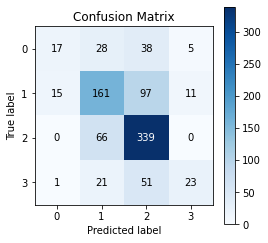

In [23]:
test_dataloader = dm.test_dataloader()
trainer = Trainer(gpus=1, logger=None)
trainer.test(text_model, test_dataloaders=test_dataloader)

In [35]:
y_hat = []
y_true = []
for _,x,y in test_dataloader:
    y_true += y.cpu()
    outputs = vision_model(x)
    _, y_pred = torch.max(outputs, dim=1)  
    
    y_hat += y_pred.cpu()

In [33]:
y_pred = [torch.max(x) for x in y_hat]

IndexError: index 1 is out of bounds for dimension 0 with size 0

In [32]:
y_pred

[tensor(0.7397),
 tensor(1.0263),
 tensor(1.0553),
 tensor(0.7884),
 tensor(0.7546),
 tensor(0.6702),
 tensor(0.7328),
 tensor(0.8982),
 tensor(0.9182),
 tensor(0.8482),
 tensor(1.0012),
 tensor(0.8599),
 tensor(0.9058),
 tensor(0.7479),
 tensor(1.0172),
 tensor(0.5973),
 tensor(0.9285),
 tensor(1.1461),
 tensor(1.0406),
 tensor(1.1107),
 tensor(0.8075),
 tensor(1.1303),
 tensor(0.6862),
 tensor(0.8267),
 tensor(0.7632),
 tensor(0.9055),
 tensor(0.8139),
 tensor(0.9056),
 tensor(0.6999),
 tensor(1.0716),
 tensor(1.3740),
 tensor(1.6450),
 tensor(1.0135),
 tensor(0.8033),
 tensor(0.9673),
 tensor(0.7962),
 tensor(1.2420),
 tensor(0.6781),
 tensor(1.2632),
 tensor(0.6464),
 tensor(0.7452),
 tensor(1.0902),
 tensor(0.7968),
 tensor(0.7724),
 tensor(1.2765),
 tensor(0.6588),
 tensor(0.8515),
 tensor(0.6845),
 tensor(0.7167),
 tensor(0.7056),
 tensor(0.7625),
 tensor(0.7964),
 tensor(0.7407),
 tensor(1.0713),
 tensor(0.8583),
 tensor(1.5170),
 tensor(0.8473),
 tensor(0.8078),
 tensor(0.6677

In [19]:
device = torch.device("cuda:0")
x=x.to(device)
y_hat = text_model(x)

In [20]:
y_hat.shape

torch.Size([32, 384])

In [21]:
print(text_model)

CaptionModalityClassifier(
  (CNNText): CNNTextBackbone(
    (embeddings): Embedding(7221, 300)
    (conv1d_1): Conv1d(300, 128, kernel_size=(3,), stride=(1,))
    (relu1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=298, stride=298, padding=0, dilation=1, ceil_mode=False)
    (conv1d_2): Conv1d(300, 128, kernel_size=(4,), stride=(1,))
    (relu2): ReLU()
    (maxpool2): MaxPool1d(kernel_size=297, stride=297, padding=0, dilation=1, ceil_mode=False)
    (conv1d_3): Conv1d(300, 128, kernel_size=(5,), stride=(1,))
    (relu3): ReLU()
    (maxpool3): MaxPool1d(kernel_size=296, stride=296, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (fc): Identity()
)


In [11]:
vision_model = get_model(vision_model_name, "shallow", 4, layers=vision_models[vision_model_id]['layers'], pretrained=True)

checkpoint = torch.load(vision_outputs_path + '/{0}/checkpoint.pt'.format(vision_models[vision_model_id]['id']))
vision_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [15]:
val_dataloader = dm.val_dataloader()

In [16]:
vision_model.eval()

accuracies = []
y_trues = []
y_hats = []
for _, x, y in val_dataloader:    
    y_hat = vision_model(x)
    _, y_pred = torch.max(y_hat, dim=1)
    
    y_trues += y
    y_hats += y_pred
    
    accuracy = 100 * torch.sum(y_pred == y.data) / (y.shape[0] * 1.0)
    accuracies.append(accuracy)
    
avg_acc = torch.stack([x for x in accuracies]).mean()

In [17]:
avg_acc

tensor(89.8380)

In [67]:
100 * torch.sum(torch.Tensor(y_trues) == torch.Tensor(y_hats)) / len(y_trues)

tensor(73)

In [60]:
text_model = CaptionModalityClassifier.load_from_checkpoint(filters=128,
                                                            embedding_dim=300,
                                                            vocab_size=8938,#7221,
                                                            num_classes=4,
                                                            train_embedding=False,                                                            
                                                            max_input_length=500,
                                                            is_multilabel=True,
                                                            target_classes=None,
                                                            #target_classes=train_dataset.le.classes_,
                                                            checkpoint_path=text_model_path)

In [70]:
text_model.eval()
correct = 0
for x, _, y in val_dataloader:
    y_pred = text_model(x) > 0.5
    for idx, _y in enumerate(y_pred):
        if _y[y[idx]]: correct += 1            

tensor([[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False,  True, False, False],
        [False,  True, False, False],
        [False, False,  True, False],
        [False, False,  True, False],
        [False, False,  True, False],
        [False, False,  True, False],
        [False, False, False, False],
        [False, False,  True, False],
        [False, False,  True, False],
        [False, False,  True, False],
        [False, False, False, False],
        [False, False,  True, False],
        [False, False, False, False],
        [False,  True, False, False],
        [False,  True, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False,  True, False, False],
        [False, False,  True, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False,  True, False],
        [Fal

In [62]:
correct / len(val_dataloader.dataset)

0.22317596566523606

In [68]:
len(val_dataloader.dataset)

466

In [69]:
val_dataloader.dataset[0]

(tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0, 

In [ ]:
device = torch.device("cuda:0")

In [10]:
model.eval()

accuracies = []
y_preds_modal = []
for x_text, x_image, y in val_dataloader:
    x_text = x_text.to(device)
    x_image = x_image.to(device)
    y = y.to(device)
    
    y_hat = model(x_text, x_image)
    _, y_pred = torch.max(y_hat, dim=1)
    
    y_preds_modal += y_pred.cpu()
    
    accuracy = 100 * torch.sum(y_pred == y.data) / (y.shape[0] * 1.0)
    accuracies.append(accuracy)
    
avg_acc = torch.stack([x for x in accuracies]).mean()

NameError: name 'model' is not defined

In [11]:
avg_acc

tensor(62.4752)

In [85]:
from sklearn.metrics import classification_report

In [86]:
print(classification_report(y_trues, y_preds_modal))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        52
           1       0.99      0.97      0.98       188
           2       1.00      0.97      0.99       157
           3       0.87      1.00      0.93        69

    accuracy                           0.97       466
   macro avg       0.96      0.97      0.96       466
weighted avg       0.97      0.97      0.97       466



In [7]:
test_dataloader = dm.test_dataloader()

In [8]:
#vision_model.eval()
with torch.no_grad():
    accuracies = []
    y_test_trues = []
    y_test_hats = []
    for _, x, y in test_dataloader:    
        y_hat = vision_model(x)
        _, y_pred = torch.max(y_hat, dim=1)

        y_test_trues += y
        y_test_hats += y_pred

        accuracy = 100 * torch.sum(y_pred == y.data) / (y.shape[0] * 1.0)
        accuracies.append(accuracy)

    avg_acc = torch.stack([x for x in accuracies]).mean()

In [9]:
avg_acc

tensor(62.4752)

In [96]:
text_model.eval()
correct = 0
for x, _, y in test_dataloader:
    y_pred = text_model(x) > 0.4
    for idx, _y in enumerate(y_pred):
        if _y[y[idx]]: correct += 1     

In [97]:
correct / len(test_dataloader.dataset)

0.24627720504009165

In [103]:
#vision_model = vision_model.eval()

with torch.no_grad():
    accuracies = []
    y_test_trues = []
    y_test_hats = []
    for _, x, y in dm.train_dataloader():    
        y_hat = vision_model(x)
        _, y_pred = torch.max(y_hat, dim=1)

        y_test_trues += y
        y_test_hats += y_pred

        accuracy = 100 * torch.sum(y_pred == y.data) / (y.shape[0] * 1.0)
        accuracies.append(accuracy)
    
avg_acc = torch.stack([x for x in accuracies]).mean()

In [104]:
avg_acc

tensor(87.5000)

In [107]:
print(classification_report(y_test_trues, y_test_hats))

              precision    recall  f1-score   support

           0       0.25      0.58      0.35        88
           1       0.94      0.77      0.85       284
           2       0.83      0.52      0.64       405
           3       0.34      0.66      0.45        96

    accuracy                           0.62       873
   macro avg       0.59      0.63      0.57       873
weighted avg       0.75      0.62      0.66       873

